# Класифікація IMDB датасету на основі RNN

Цей ноутбук демонструє класифікацію тексту на датасеті IMDB за допомогою рекурентної нейронної мережі (RNN).

In [3]:
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(True)


# 1. Завантаження датасету IMDB
max_features = 10000  # Розмір словникового запасу
max_len = 500  # Максимальна довжина відгуку (обрізання або доповнення)

# Датасет було завантажено за посиланням https://storage.googleapis.com/tensorflow/tf-keras-datasets/imdb.npz
(X_train, y_train), (X_test, y_test) = imdb.load_data(path= "imdb.npz", num_words=max_features)

# 2. Попередня обробка даних (доповнення або обрізання)
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)


Matplotlib created a temporary cache directory at /var/folders/t1/w5ktxn5j25n31cysspss6y880000gn/T/matplotlib-zhuo96si because the default path (/Users/raymond/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


Num GPUs Available:  1


In [2]:
embedding_dim = 32
model = Sequential([
    Embedding(input_dim=max_features, output_dim=embedding_dim),  # Word embedding
    SimpleRNN(32, return_sequences=False),  # RNN шар
    Dense(1, activation='sigmoid')
])

# 4. Компіляція моделі
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Перед викликом summary потрібно \"побудувати\" модель, подавши на неї вхідні дані
model.build(input_shape=(None, max_len))
model.summary()


2024-12-20 21:46:41.341331: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-12-20 21:46:41.341359: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-12-20 21:46:41.341364: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-12-20 21:46:41.341379: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-20 21:46:41.341393: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,113 (1.23 MB)

 Trainable params: 322,113 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [2]:
# 5. Train the model
batch_size = 64
epochs = 5
with tf.device('/CPU:0'):
 history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)


NameError: name 'tf' is not defined

In [14]:
# 6. Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8149 - loss: 0.5710
Test Loss: 0.5618375539779663, Test Accuracy: 0.8166800141334534


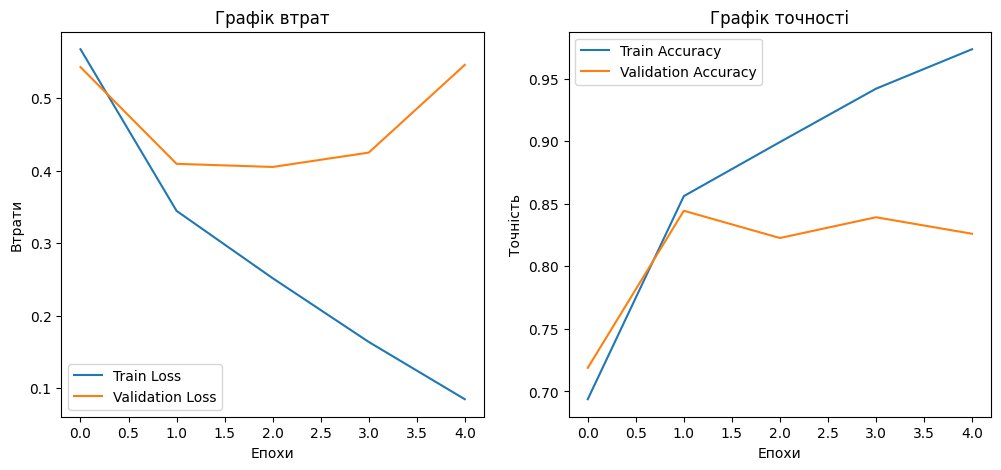

In [15]:
# Візуалізація навчання
plt.figure(figsize=(12, 5))

# Графік втрат
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Графік втрат')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.legend()

# Графік точності
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Графік точності')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.legend()

plt.show()

* **Графік втрат:** Спостерігається стабільне зниження втрат на тренувальних даних (Train Loss), але валідаційні втрати (Validation Loss) після кількох епох починають зростати. Це вказує на перенавчання, коли модель починає "запам'ятовувати" тренувальні дані, але її узагальнення на нові дані погіршується.

* **Графік точності:** Точність на тренувальних даних (Train Accuracy) постійно зростає і досягає майже 100%, але точність на валідаційних даних (Validation Accuracy) спочатку зростає, а потім стабілізується чи навіть знижується. Це також свідчить про перенавчання.

* **Висновок:** Для покращення моделі можна спробувати регуляторизацію (наприклад, Dropout)

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.6079 - loss: 0.6423 - val_accuracy: 0.7866 - val_loss: 0.4590
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.8008 - loss: 0.4642 - val_accuracy: 0.8154 - val_loss: 0.4333
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.8806 - loss: 0.3149 - val_accuracy: 0.8324 - val_loss: 0.3926


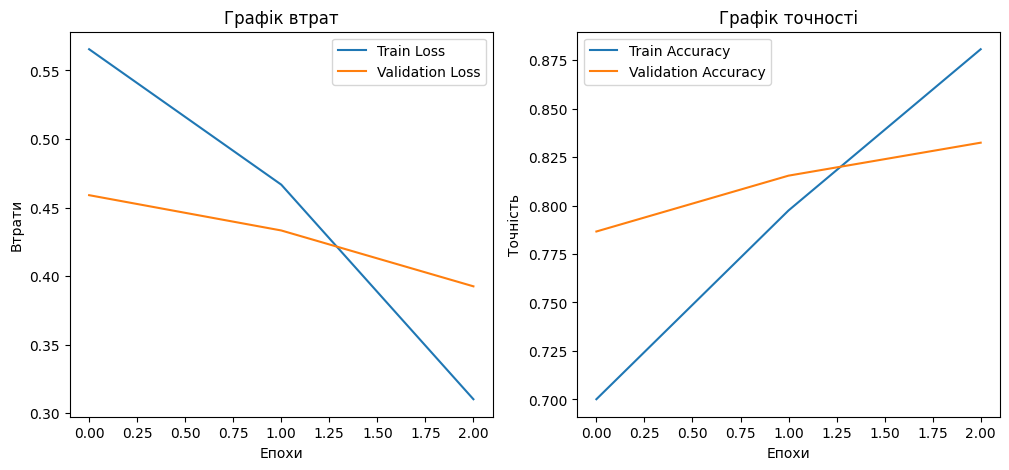

In [16]:
# Побудова моделі RNN з регуляторизацією Dropout
embedding_dim = 32
model = Sequential([
    Embedding(input_dim=max_features, output_dim=embedding_dim),
    SimpleRNN(32, return_sequences=False),
    Dropout(0.5),  # Dropout для запобігання перенавчанню
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Навчання моделі
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.2)

# Візуалізація навчання
plt.figure(figsize=(12, 5))

# Графік втрат
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Графік втрат')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.legend()

# Графік точності
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Графік точності')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.legend()

plt.show()


* **Графік втрат:** Втрати на тренувальних та валідаційних даних стабільно зменшуються, що вказує на покращення узагальнення моделі. Валідаційні втрати слідують за тренувальними без явного перенавчання.

* **Графік точності:** Точність на тренувальних та валідаційних даних зростає, і їхні значення близькі, що підтверджує, що модель не перенавчається і добре узагальнює результати.

* **Висновок:** Додавання Dropout позитивно вплинуло на стабільність навчання, допомогло уникнути перенавчання та покращити продуктивність моделі.

In [18]:
# Перевірка роботи моделі на прикладах
index_to_word = {index: word for word, index in imdb.get_word_index().items()}  # Перетворення індексів у слова
index_to_word = {index + 3: word for index, word in index_to_word.items()}
index_to_word[0] = "<PAD>"
index_to_word[1] = "<START>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

def decode_review(encoded_review):
    return " ".join([
        index_to_word.get(i, "?") for i in encoded_review
        if i > 3  # Видалити <PAD>, <START>, <UNK>, <UNUSED>
    ])


# Вибір випадкового відгуку з тестового набору
random_index = np.random.randint(0, len(X_test))
review = X_test[random_index]
true_label = y_test[random_index]
predicted_label = (model.predict(review.reshape(1, -1)) > 0.5).astype("int32")[0][0]

# Декодування відгуку
decoded_review = decode_review(review)

print("Відгук:")
print(decoded_review)
print("\nСправжня мітка:", "Позитивний" if true_label == 1 else "Негативний")
print("Прогнозована мітка:", "Позитивний" if predicted_label == 1 else "Негативний")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Відгук:
it is a that it takes a lot of effort to make a bad movie this one is no exception br br i am no lover of but their amazingly simplistic view of the world and their ability to everything to black and white as well as make events even fictional ones in novels fit an agenda that bears little or no relationship to complexity of any kind is irritating in the extreme br br smith is but weaves intricate tales that deserve more than has been delivered by this awful of a movie br br sad really for those who will never read smith they will be left with a less than decent portrayal of his egyptian series which has to be said is gigantic in its exposition br br the indiana jones movies were snappy to attempt to that by smith's novels into this production misses out by a country mile br br pathetic except for the photography and art

Справжня мітка: Негативний
Прогнозована мітка: Негативний
